In [99]:
import unicodedata
from matplotlib import pyplot as plt
import snip
from numpy import array
import numpy as np

In [4]:
raw_data = snip.loadmat('./XRMBsJW11m.mat')

In [5]:
all_data = raw_data['data']
all_label = raw_data['Phones']

In [6]:
all_data

{'view1': {'testing': array([[ 0.75839544,  0.85485019,  1.15535141, ...,  1.10260294,
           0.73618497, -0.4001714 ],
         [-0.06151944, -0.16391155, -0.62668184, ..., -1.28935867,
          -0.45952176,  0.16576458],
         [ 0.18424131, -0.2570127 , -0.56480874, ...,  2.40281748,
           1.49515556,  1.29634259],
         ..., 
         [ 0.88711545,  0.45564091,  0.09410712, ..., -1.76947163,
          -1.13538791, -0.19835406],
         [ 0.34638978,  0.730658  ,  0.71457892, ..., -1.45181165,
          -1.35648485, -0.95051196],
         [-3.27746931, -3.06618534, -2.23126583, ..., -2.36161483,
          -2.20294701, -1.69900866]]),
  'training': array([[ 2.23709392,  2.37557625,  2.38950448, ...,  2.44881734,
           2.56178401,  2.6315746 ],
         [ 0.12286918, -0.41873219, -0.58477688, ..., -0.29324309,
          -0.82708961, -1.17823921],
         [-2.17243276, -2.02364584, -1.93719258, ..., -2.02771641,
          -2.07484404, -2.071841  ],
         ..., 


In [7]:
temp = all_data['view1']['testing']

In [8]:
temp[2:4,:]

array([[ 0.18424131, -0.2570127 , -0.56480874, ...,  2.40281748,
         1.49515556,  1.29634259],
       [ 0.79609227,  0.63521523, -0.01053581, ...,  1.75034065,
         2.4646991 ,  1.05085186]])

In [9]:
all_label

{'testing': array(['"AO"', '"AO"', '"AO"', ..., '"IY"', '"IY"', '"IY"'], dtype=object),
 'training': array(['"AA"', '"AA"', '"AA"', ..., '"EH"', '"EH"', '"EH"'], dtype=object),
 'tuning': array(['"EH"', '"EH"', '"EH"', ..., '"EH"', '"EH"', '"EH"'], dtype=object)}

In [10]:
training_lable = all_label['training'].transpose()
testing_lable = all_label['testing'].transpose()
tuning_lable = all_label['tuning'].transpose()

In [11]:
print('len(trainning),tuning and tesing = %i,%i,%i'%(len(training_lable),len(testing_lable),len(tuning_lable)))

len(trainning),tuning and tesing = 8527,2933,2573


In [12]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(training_lable)

LabelEncoder()

In [88]:
le.classes_

array(['"AA"', '"AE"', '"AO"', '"EH"', '"IY"', '"OW"', '"UW"'], dtype=object)

In [89]:
training_code = le.transform(training_lable)
tuning_code = le.transform(tuning_lable)
testing_code = le.transform(testing_lable)

# (a) Use baseline 39-features to do KNN

In [134]:
# First get dev and test data with baseline feature only
training_data = all_data['view1']['training'][117:156,:].transpose()
tuning_data = all_data['view1']['tuning'][117:156,:].transpose()
testing_data = all_data['view1']['testing'][117:156,:].transpose()

In [16]:
from sklearn.neighbors import KNeighborsClassifier
list_ks = [4,8,12,16]

In [17]:
knn_objs = []
for k in list_ks:
    print('(progress) training for KNN k=%i!'%k)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(training_data,training_code)
    knn_objs.append(knn)

(progress) training for KNN k=4!
(progress) training for KNN k=8!
(progress) training for KNN k=12!
(progress) training for KNN k=16!


In [18]:
for i in range(len(list_ks)):
    score = knn_objs[i].score(tuning_data,tuning_code)
    print('(info) acurracy for k=%i on tuning set = %.3f'%(list_ks[i],score))

(info) acurracy for k=4 on tuning set = 0.820
(info) acurracy for k=8 on tuning set = 0.814
(info) acurracy for k=12 on tuning set = 0.812
(info) acurracy for k=16 on tuning set = 0.808


So best k to use based on tuning set is k=4. Accuracy for testing set is as follows

In [19]:
test_score = knn_objs[0].score(testing_data,testing_code)

In [20]:
print('(info) acurracy for k=4 on testing set = %.3f'%test_score)

(info) acurracy for k=4 on testing set = 0.937


# (b) PLS+MFCC39

In [21]:
# First get dev and test data 
training_view1 = all_data['view1']['training']
tuning_view1 = all_data['view1']['tuning']
testing_view1 = all_data['view1']['testing']
training_view2 = all_data['view2']['training']
tuning_view2 = all_data['view2']['tuning']
testing_view2 = all_data['view2']['testing']
view1 = [training_view1,tuning_view1,testing_view1]
view2 = [training_view2,tuning_view2,testing_view2]

In [38]:
testing_view2[1,1]

-0.12440106330985479

In [22]:
# mean center everything
center = lambda m: m.transpose()-m.mean(axis=1)

In [23]:
for i in range(len(view1)):
    view1[i] = center(view1[i]).transpose()
    view2[i] = center(view2[i]).transpose()

In [30]:
size_training = view1[0].shape[1]

In [31]:
Cxy = view1[0]@view2[0].transpose()/size_training

In [32]:
Cxy.shape

(273, 112)

In [40]:
# Find eigenvalues and eigenvectors of Cxy
from scipy import linalg
U, s, Vh = linalg.svd(Cxy)

In [58]:
# U=(u1,u2,u3,..,u_dx), with Cxy@u_i = lambda_i u_i
U.shape

(273, 273)

In [66]:
view1_tuning = view1[1]

In [67]:
view1_tuning.shape

(273, 2573)

In [72]:
PLS_subspace = U[:,:2]
PLS_subspace = PLS_subspace.transpose()
PLS_subspace.shape

(2, 273)

In [222]:
def group_codes(old_code_array):
    """
    group codes into smaller groups
    """
    # 4/6->10,0/1->20,else->30
    conversion = {4:'b',6:'b',0:'r',1:'r'}
    return np.array([conversion.get(code,'w') for code in old_code_array])

In [76]:
# Get X projection to d singular vectors of Cxy
new_feature = U[:,:2].transpose()@view1[1]

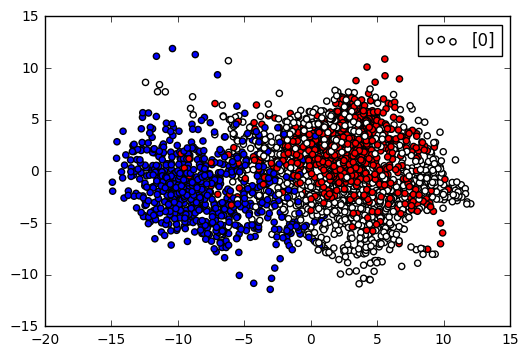

In [224]:
new_color_tuning = group_codes(tuning_code)
plt.scatter(new_feature[0,:],new_feature[1,:],c = new_color_tuning,label=[0])
plt.legend(loc='best')
plt.show()

In [98]:
# test concatinating learned feature with original features
training_data.shape

(8527, 39)

In [100]:
new_feature.shape

(2, 2573)

In [176]:
# define a kNN test code
def kNN_test(training_set,tuning_set):
    """
    input: training and tuning set , R n*dx
    output: knn score based on tuning set
    """
    best_score = 0
    for k in list_ks:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(training_set,training_code)
        score = knn.score(tuning_set,tuning_code)
        print('(info) acurracy for k=%i on tuning set = %.4f'%(k,score))     
        best_score = score
    return best_score

In [135]:
# use mean centered datasets for both training and tuning purpose
training_data.mean(axis=1)

array([ 0.08080585,  0.02273293, -0.02311535, ..., -0.00170573,
       -0.01027316, -0.0177443 ])

In [177]:
def eval_RL(U,hyper_list):
    """
    Use kNN to evaluate learned representations
    input: Learned subspace basis, list of hyper parameters, which is first d eigenvectors
    output: print out results of kNN evaluation
    """
    best_d = 0
    best_score = 0
    for d in hyper_list:
        print('(info) Evaluationg with d=%i.'%d)
        new_training_set = U[:,:d].T@view1[0]
        new_training_set = np.concatenate((view1[0][117:156,:].T,new_training_set.T),axis=1)
    #     print(new_training_set.shape)
        new_tuning_set = U[:,:d].T@view1[1]
        new_tuning_set = np.concatenate((view1[1][117:156,:].T,new_tuning_set.T),axis=1)
    #     print(new_tuning_set.shape)
        score = kNN_test(new_training_set,new_tuning_set)
        if score>best_score:
            best_score = score
            best_d = d
    return best_score,best_d

In [152]:
PLS_dims = [10,30,50,70,90,110]
list_ks = [4]
# PLS_dims = [10,110]
# list_ks = [4,16].
eval_RL(U,PLS_dims)

(info) PLS with d=10.
(info) acurracy for k=4 on tuning set = 0.815
(info) PLS with d=30.
(info) acurracy for k=4 on tuning set = 0.818
(info) PLS with d=50.
(info) acurracy for k=4 on tuning set = 0.827
(info) PLS with d=70.
(info) acurracy for k=4 on tuning set = 0.829
(info) PLS with d=90.
(info) acurracy for k=4 on tuning set = 0.830
(info) PLS with d=110.
(info) acurracy for k=4 on tuning set = 0.829


Therefore, for PLS, the best kNN accuracy on tuning set is 82.9% with k=4 and d=70

# (c) CCA

In [142]:
# First get Cxx, Cyy 
Cxx = (view1[0]@view1[0].T)/size_training
Cyy = (view2[0]@view2[0].T)/size_training

In [147]:
view1_size = len(Cxx)
view2_size = len(Cyy)

In [143]:
reg_list = [e-8,e-6,e-4,e-2,e-1,10]
reg_list = [e-8,10]
CCA_d = [10,30,50,70,90,110]

(273, 273)

In [163]:
def print_diag(M):
    for i in range(min(len(M),5)):
        print('lambda_%i=%.3f'%(i,M[i,i]))

In [180]:
reg_list = [1e-8,1e-6,1e-4,1e-2,1e-1,10]
CCA_d = [10,30,50,70,90,110]
# reg_list = [1e-8,10]
# CCA_d = [10,110]
best_score,best_d,best_regX,best_regY = 0,0,0,0
for regX in reg_list:
    for regY in reg_list:
        print('(info) CCA with regX=%.2e,regY=%.2e'%(regX,regY))
        # find egien vectors of Cxx-1CxyCyy-1Cxy.T
        new_m = linalg.inv(Cxx+regX*np.identity(view1_size))@Cxy@linalg.inv(Cyy+regY*np.identity(view2_size))@Cxy.T
        s,U_CCA = linalg.eig(new_m)
        print('first 5 eigenvals are',s[0:5])
        # Get first d dim eigenvector projections of tuning data for knn evaluation
        score,d = eval_RL(U_CCA,CCA_d)
        if score>best_score:
            best_score = score
            best_d = d
            best_regX = regX
            best_regY = regY
print('\n(Result) Best accuracy = %.4f for d=%i, regX =%.2e, regY=%.2e.'%(best_score,best_d,best_regX,best_regY))

(info) CCA with regX=1.00e-08,regY=1.00e-08
first 5 eigenvals are [ 0.82396268+0.j  0.77992971+0.j  0.76725809+0.j  0.63307389+0.j
  0.61755332+0.j]
(info) Evaluationg with d=10.


/Users/ray/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/ray/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:373: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


(info) acurracy for k=4 on tuning set = 0.8228
(info) Evaluationg with d=30.
(info) acurracy for k=4 on tuning set = 0.8228
(info) Evaluationg with d=50.
(info) acurracy for k=4 on tuning set = 0.8228
(info) Evaluationg with d=70.
(info) acurracy for k=4 on tuning set = 0.8228
(info) Evaluationg with d=90.
(info) acurracy for k=4 on tuning set = 0.8224
(info) Evaluationg with d=110.
(info) acurracy for k=4 on tuning set = 0.8232
(info) CCA with regX=1.00e-08,regY=1.00e-06
first 5 eigenvals are [ 0.82017402+0.j  0.77407534+0.j  0.75938513+0.j  0.62451964+0.j
  0.58941083+0.j]
(info) Evaluationg with d=10.
(info) acurracy for k=4 on tuning set = 0.8228
(info) Evaluationg with d=30.
(info) acurracy for k=4 on tuning set = 0.8224
(info) Evaluationg with d=50.
(info) acurracy for k=4 on tuning set = 0.8224
(info) Evaluationg with d=70.
(info) acurracy for k=4 on tuning set = 0.8216
(info) Evaluationg with d=90.
(info) acurracy for k=4 on tuning set = 0.8220
(info) Evaluationg with d=110.
(i

(Result) Using k=4 kNN classifier, `Best accuracy = 0.8473 for d=30, regX =1.00e-01, regY=1.00e-08.

# (d) Plotting top two CCA

In [200]:
from matplotlib import colors 

In [202]:
colors.ColorConverter(r)

NameError: name 'r' is not defined

In [181]:
new_m = linalg.inv(Cxx+1e-1*np.identity(view1_size))@Cxy@linalg.inv(Cyy+1e-8*np.identity(view2_size))@Cxy.T
s,U_CCA = linalg.eig(new_m)
print('first 5 eigenvals are',s[0:5])

first 5 eigenvals are [ 0.80900670+0.j  0.75721871+0.j  0.75555958+0.j  0.60496107+0.j
  0.58749749+0.j]


In [225]:
new_training_set = U_CCA[:,:2].T@view1[0]
#     print(new_training_set.shape)
new_testing_set = U_CCA[:,:2].T@view1[2]

In [188]:
le.classes_

array(['"AA"', '"AE"', '"AO"', '"EH"', '"IY"', '"OW"', '"UW"'], dtype=object)

/Users/ray/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:533: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


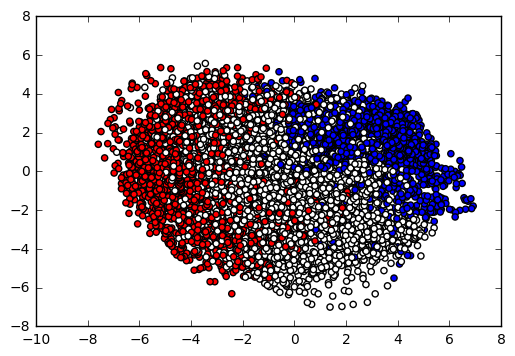

In [223]:
new_color_training = group_codes(training_code)
plt.scatter(new_training_set[0,:],new_training_set[1,:],c=new_color_training)
plt.show()

In above plot, red=['UW','IY'] which is closed, and blue=['AE','AA] (open) and white is other phones

/Users/ray/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:533: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


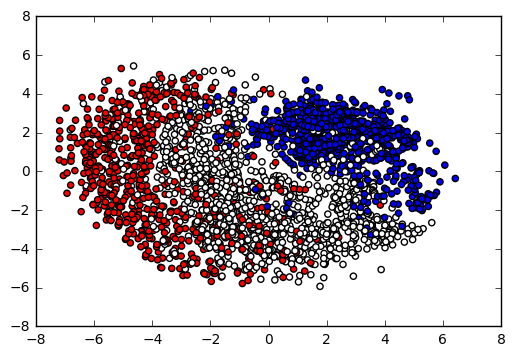

In [226]:
new_color_testing = group_codes(testing_code)
plt.scatter(new_testing_set[0,:],new_testing_set[1,:],c=new_color_testing)
plt.show()